In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from io import StringIO
import datetime

In [2]:
powerdata = glob.glob('powerdata/*.csv')
tempdata = glob.glob('tempdata/*.csv')

powerframes = []
tempframes = []

for path in powerdata:
    with open(path, 'r') as f:
        csv = f.read()
        df = pd.read_csv(StringIO(csv.replace('−', '-')), delimiter=';', names=['date', 'energy', 'outdoor_temperature'], decimal=',', skiprows=[0], index_col='date', parse_dates=True)
        powerframes.append(df)

for path in tempdata:
    df = pd.read_csv(path, delimiter=',', names=['date', 'indoor_temperature', 'indoor_humidity'], index_col='date', parse_dates=True)
    tempframes.append(df)

power = pd.concat(powerframes)
temp = pd.concat(tempframes).resample('h').mean()
data = power.join(temp, how='right')
data = data.drop(columns=['indoor_humidity'])
data = data.dropna()
print(data)

                     energy  outdoor_temperature  indoor_temperature
date                                                                
2022-02-15 00:00:00    4.03                  1.5           23.707027
2022-02-15 01:00:00    4.22                  1.6           23.821349
2022-02-15 02:00:00    4.77                  1.7           23.974303
2022-02-15 03:00:00   14.75                  1.6           23.616276
2022-02-15 04:00:00   10.86                  1.4           22.058696
...                     ...                  ...                 ...
2022-03-09 19:00:00    6.15                 -3.2           22.365886
2022-03-09 20:00:00    6.93                 -3.2           22.521014
2022-03-09 21:00:00    5.86                 -3.4           21.358919
2022-03-09 22:00:00    7.35                 -3.8           20.751561
2022-03-09 23:00:00    5.77                 -3.7           20.506912

[549 rows x 3 columns]


<AxesSubplot:xlabel='date'>

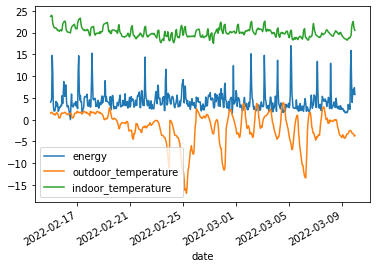

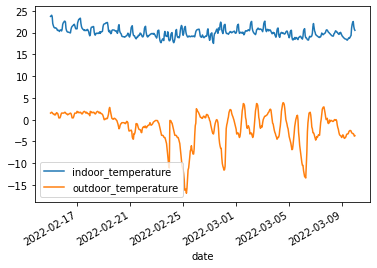

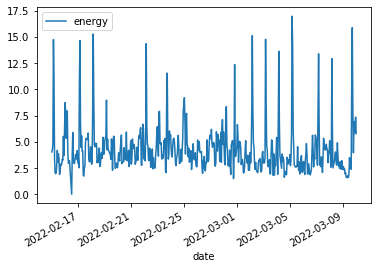

In [3]:
data.plot()
data.plot(y=['indoor_temperature', 'outdoor_temperature'])
data.plot(y=['energy'])

<AxesSubplot:xlabel='date'>

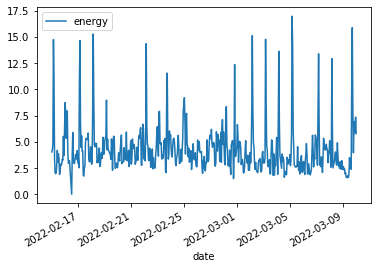

In [4]:
index_to_delete = []

for row in data.itertuples():
    idx = row[0]
    value = row.energy
    if value > 8 and idx not in index_to_delete:
        index_to_delete += list(pd.date_range(idx-datetime.timedelta(hours=1), idx+datetime.timedelta(hours=2), freq='1h'))

#data = data.loc[~data.index.isin(index_to_delete)]
#data = data.interpolate(method='linear', limit_direction='forward', axis=0)
data.plot(y='energy')

<AxesSubplot:xlabel='date'>

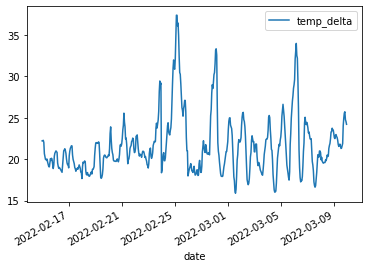

In [5]:
data['temp_delta'] = data.indoor_temperature - data.outdoor_temperature
data.plot(y='temp_delta')

In [6]:
print(data)

                     energy  outdoor_temperature  indoor_temperature  \
date                                                                   
2022-02-15 00:00:00    4.03                  1.5           23.707027   
2022-02-15 01:00:00    4.22                  1.6           23.821349   
2022-02-15 02:00:00    4.77                  1.7           23.974303   
2022-02-15 03:00:00   14.75                  1.6           23.616276   
2022-02-15 04:00:00   10.86                  1.4           22.058696   
...                     ...                  ...                 ...   
2022-03-09 19:00:00    6.15                 -3.2           22.365886   
2022-03-09 20:00:00    6.93                 -3.2           22.521014   
2022-03-09 21:00:00    5.86                 -3.4           21.358919   
2022-03-09 22:00:00    7.35                 -3.8           20.751561   
2022-03-09 23:00:00    5.77                 -3.7           20.506912   

                     temp_delta  
date                         

In [7]:
X = []
y = []

for index, row in data.iterrows():
    X.append([row.temp_delta])
    y.append([row.energy])

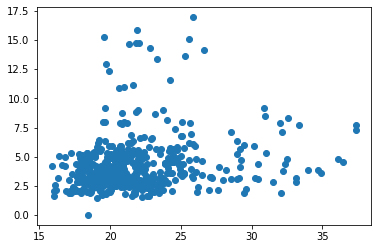

In [8]:
plt.scatter(X, y)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=False)
print("Total set:", len(X))
print("Training set:", len(X_train))
print("Validation set:", len(X_val))
print("Testing set:", len(X_test))

Total set: 549
Training set: 439
Validation set: 55
Testing set: 55


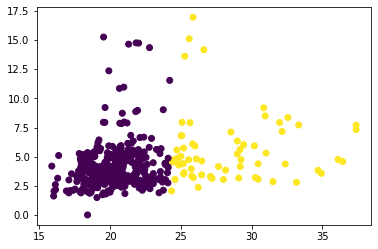

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
kmeans_pred = kmeans.predict(X_train)

plt.scatter(X_train, y_train, c=kmeans_pred)

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

clf = linear_model.LinearRegression()
clf.fit(X_train_poly, y_train)

LinearRegression()

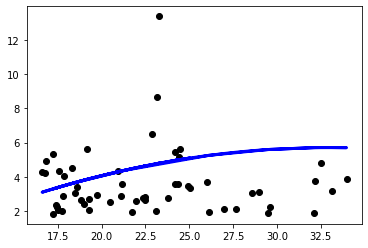

In [12]:
X_val_poly = poly.transform(X_val)
y_val_pred = clf.predict(X_val_poly)

plt.scatter(X_val, y_val, color="black")
plt.plot(X_val, y_val_pred, color="blue", linewidth=3)

#plt.xticks(())
#plt.yticks(())